In [2]:
# general python libs
import pandas as pd
import requests
import time
import json
from datetime import datetime
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from my_directory_loader import MyDirectoryLoader 

# langchain
from langchain import LLMChain
from langchain.prompts.few_shot import FewShotPromptTemplate
from langchain.prompts.prompt import PromptTemplate
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.agents import Tool, AgentType, initialize_agent, LLMSingleActionAgent
from langchain.callbacks import get_openai_callback
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from langchain.tools import StructuredTool
from langchain.text_splitter import RecursiveCharacterTextSplitter
import tiktoken
from langchain.schema import Document
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.schema import Document
from langchain.chains import RetrievalQA


## Tool 1 - schema explorer

In [3]:
from rdflib import Graph, URIRef

class SchemaExplorerTool:
    def __init__(self, schema_path):
        self.schema_graph = Graph()
        self.load_schema(schema_path)
    
    def load_schema(self, schema_path):
        self.schema_graph.parse(schema_path)
    
    def explore_schema(self):
        schema_info = []
        
        for subject, predicate, obj in self.schema_graph:
            subject_name = self.get_label(subject)
            predicate_name = self.get_label(predicate)
            object_name = self.get_label(obj)
            
            schema_info.append({
                "subject": str(subject),
                "subject_name": subject_name,
                "predicate": str(predicate),
                "predicate_name": predicate_name,
                "object": str(obj),
                "object_name": object_name
            })

        return schema_info
    
    def get_label(self, resource):
        label_predicate = URIRef("http://www.w3.org/2000/01/rdf-schema#label")
        label = self.schema_graph.value(resource, label_predicate)

        if label:
            return label.toPython()

        return str(resource)

In [4]:
# initiating instance of schema explorer

#path = "practice_schema/ontolex.rdf"
#SchemaExplorer = SchemaExplorerTool(path)

# Tool name
tool_name='schema explorer'
tool_desc = """
Q&A rdf schema - useful for questions and information about the schema of the rdf. This tool can also be used for follow up questions from the user or agent.
"""
chain_type='stuff' #'stuff' or 'map_reduce'


OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(
    model_name="gpt-3.5-turbo",
    temperature=0.7,
    max_tokens=1500,
    openai_api_key=OPENAI_API_KEY,
)


In [5]:
from SPARQLWrapper import SPARQLWrapper2

endpoint_url = "https://query.wikidata.org/sparql"
sparql = SPARQLWrapper2(endpoint_url)
#sparql.setReturnFormat(JSON)
sparql.setQuery("""
    SELECT DISTINCT ?class ?label
    WHERE {
        ?s a ?class .
        OPTIONAL {?class rdfs:label ?label . FILTER (lang(?label) = "en")}
    }
    LIMIT 4
    """)

for result in sparql.query().bindings:  #.queryAndConvert()['results']['bindings']:
    print(result)
    #print(f"{result['label'].lang}, {result['label'].value}")

{'class': Value(uri:'http://schema.org/Dataset')}
{'class': Value(uri:'http://wikiba.se/ontology#GeoAutoPrecision')}
{'class': Value(uri:'http://wikiba.se/ontology#Property')}
{'class': Value(uri:'http://www.w3.org/ns/lemon/ontolex#LexicalSense')}


## Tool 1 - Load schema into vector DB

In [6]:
class AgentToolFromPDFs:
    def __init__(
        self,
        dir,
        ext,
        search_strings_and_replacements,
        chunk_size,
        chunk_overlap,
        tool_name,
        tool_desc,
        chain_type,
        model_name,
        temperature,
        max_tokens,
    ):
        self.dir = dir
        self.ext = ext
        self.search_strings_and_replacements = search_strings_and_replacements
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.tool_name = tool_name
        self.tool_desc = tool_desc
        self.chain_type = chain_type
        self.model_name = model_name
        self.temperature = temperature
        self.max_tokens = max_tokens

    def generate_an_agent_tool(self):
        print('Loading documents from the pdfs')
        loader = MyDirectoryLoader(self.dir, glob="**/*." + str(self.ext))
        data = loader.load()
        print(data)
        # Cleaning the documents
        print('Cleaning the text in each document')
        for document in data:
            for search_string, replacement_string in self.search_strings_and_replacements:
                document.page_content = document.page_content.replace(
                    search_string, replacement_string
                )
            document.page_content = (
                document.page_content.replace("\n", " ")
                .replace("(", "")
                .replace(")", "")
            )
            document.page_content = re.sub(r" {2,}", " ", document.page_content)
            document.page_content = re.sub(
                r"[^a-zA-Z0-9]{4,}", "", document.page_content
            )
        print('Merging the documents')
        merged_page_content = ""
        for document in data:
            merged_page_content += document.page_content
        print(data)

        # Lets count tokens
        tokenizer = tiktoken.get_encoding('cl100k_base')
        def tiktoken_len(text):
            tokens = tokenizer.encode(
                text,
                disallowed_special=()
            )
            return len(tokens)

        token_counts = [tiktoken_len(doc.page_content) for doc in data]

        print(f"""Min: {min(token_counts)}
        Avg: {int(sum(token_counts) / len(token_counts))}
        Max: {max(token_counts)}""")

        # set style and color palette for the plot
        sns.set_style("whitegrid")
        sns.set_palette("muted")

        # create histogram
        plt.figure(figsize=(12, 6))
        sns.histplot(token_counts, kde=False, bins=50)

        # customize the plot info
        plt.title("Token Counts Histogram before the merging")
        plt.xlabel("Token Count")
        plt.ylabel("Frequency")

        plt.show()

        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=self.chunk_size, 
                                                                    chunk_overlap=self.chunk_overlap,
                                                                    #length_function=tiktoken_len,
                                                                    separators=['PREFIX', '\n\n', '\n', ' ']
        )

        print('Split the documents')
        data = text_splitter.create_documents([merged_page_content])
         # Note: If you're using PyPDFLoader then it will split by page for you already
        print (f'You have {len(data)} document(s) in your data')
        print(data)

        # Assuming data is a list of objects with a page_content attribute
        token_counts = [tiktoken_len(doc.page_content) for doc in data]

        print(f"""Min: {min(token_counts)}
        Avg: {int(sum(token_counts) / len(token_counts))}
        Max: {max(token_counts)}""")

        # set style and color palette for the plot
        sns.set_style("whitegrid")
        sns.set_palette("muted")

        # create histogram
        plt.figure(figsize=(12, 6))
        sns.histplot(token_counts, kde=False, bins=50)

        # customize the plot info
        plt.title("Token Counts Histogram after split with tiktoken_encoder")
        plt.xlabel("Token Count")
        plt.ylabel("Frequency")

        plt.show()
        
        print (f'You have {len(data)} document(s) remaining after filtering in your data')
        # Now filtered_data will only contain documents with at least 100 characters.


        OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
        embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)
        db = Chroma.from_documents(data, embeddings)

        llm = ChatOpenAI(
            model_name=self.model_name,
            temperature=self.temperature,
            max_tokens=self.max_tokens,
            openai_api_key=OPENAI_API_KEY,
        )

        retriever = RetrievalQA.from_chain_type(
            llm=llm,
            chain_type=self.chain_type,
            retriever=db.as_retriever(),
        )

        tool = [
            Tool(
                func=retriever.run,
                description=self.tool_desc,
                name=self.tool_name,
            )
        ]
        print('Tool '+ str(self.tool_name)+' was created')
        return tool


Loading documents from the pdfs
[Document(page_content='{\'wdSubclass\': \'Q5014087\', \'wdParentClass\': \'Q27868211\', \'wdSubclassLabel\': \'CSF/serum albumin ratio\', \'wdParentClassLabel\': \'medical tests on cerebrospinal fluid\'} {\'wdSubclass\': \'Q29643832\', \'wdParentClass\': \'Q27868211\', \'wdSubclassLabel\': \'abnormality of the cerebrospinal fluid\', \'wdParentClassLabel\': \'medical tests on cerebrospinal fluid\'} {\'wdSubclass\': \'Q104045804\', \'wdParentClass\': \'Q27868211\', \'wdSubclassLabel\': \'cerebrospinal fluid culture\', \'wdParentClassLabel\': \'medical tests on cerebrospinal fluid\'} {\'wdSubclass\': \'Q3109350\', \'wdParentClass\': \'Q27868211\', \'wdSubclassLabel\': \'CSF glucose\', \'wdParentClassLabel\': \'medical tests on cerebrospinal fluid\'} {\'wdSubclass\': \'Q3408236\', \'wdParentClass\': \'Q27868211\', \'wdSubclassLabel\': \'CSF total protein\', \'wdParentClassLabel\': \'medical tests on cerebrospinal fluid\'} {\'wdSubclass\': \'Q14471999\', \'w

Min: 6413
        Avg: 6413
        Max: 6413


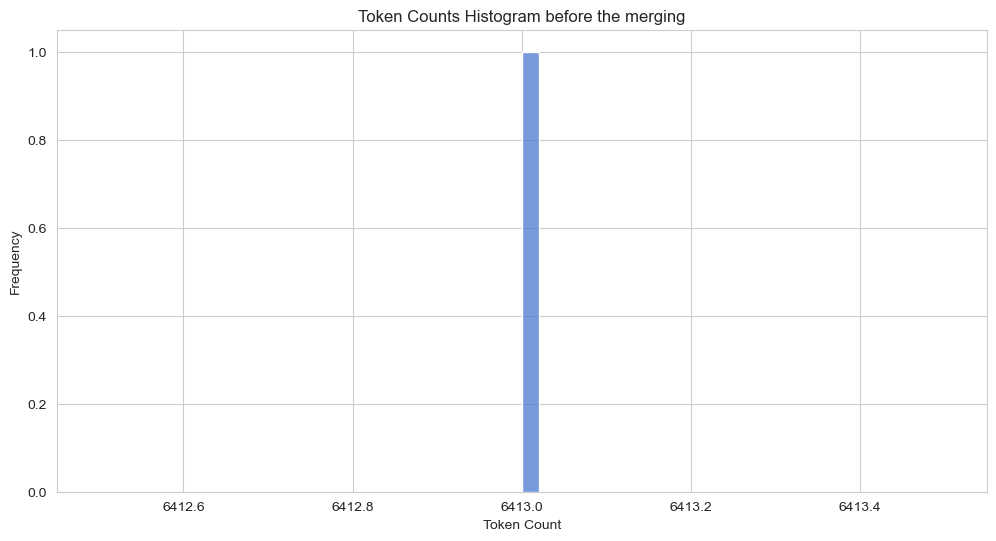

Split the documents
You have 15 document(s) in your data
[Document(page_content="{'wdSubclassQ5014087wdParentClassQ27868211wdSubclassLabelCSF/serum albumin ratiowdParentClassLabelmedical tests on cerebrospinal fluidwdSubclassQ29643832wdParentClassQ27868211wdSubclassLabelabnormality of the cerebrospinal fluidwdParentClassLabelmedical tests on cerebrospinal fluidwdSubclassQ104045804wdParentClassQ27868211wdSubclassLabelcerebrospinal fluid culturewdParentClassLabelmedical tests on cerebrospinal fluidwdSubclassQ3109350wdParentClassQ27868211wdSubclassLabelCSF glucosewdParentClassLabelmedical tests on cerebrospinal fluidwdSubclassQ3408236wdParentClassQ27868211wdSubclassLabelCSF total proteinwdParentClassLabelmedical tests on cerebrospinal fluidwdSubclassQ14471999wdParentClassQ27868211wdSubclassLabelPandy's testwdParentClassLabelmedical tests on cerebrospinal fluidwdSubclassQ5014091wdParentClassQ27868211wdSubclassLabelCSF albuminwdParentClassLabelmedical tests on cerebrospinal fluidwdSubclassQ

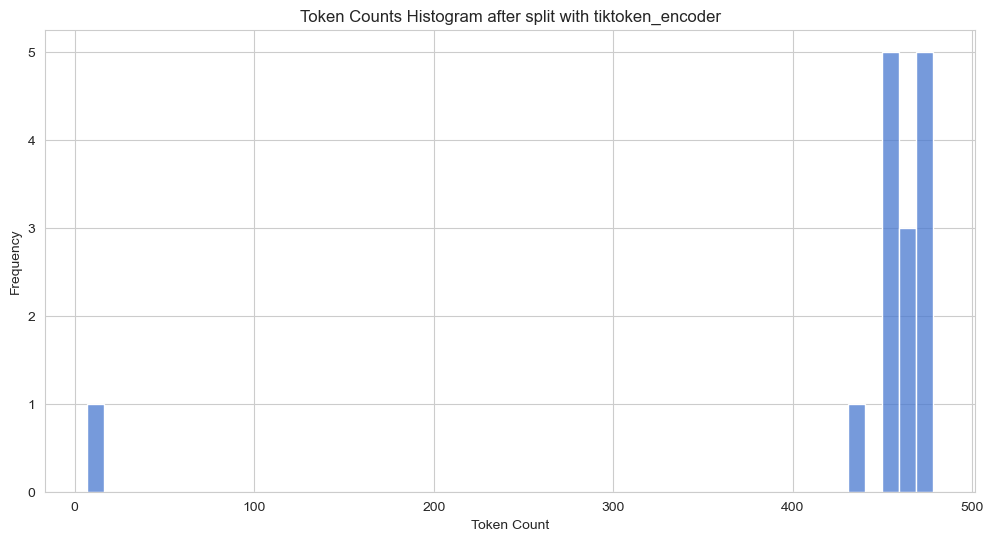

You have 15 document(s) remaining after filtering in your data
Tool schema explorer was created


In [7]:
# PDFs
dir='chemistry_schema'
ext='txt'  # the string pattern for matching the files in the folder
search_strings_and_replacements = [
    (r"2:51 PMWhy ", ""),
    (r'test234',''),
    (r":", " ="),
    (r"{", "NEW CLASS: ")
    ]

search_strings_and_replacements = [
    (r"2:51 PMWhy ", ""),
    (r'test234','')]

# Chunking
chunk_size=500
chunk_overlap=25

# Tool name
tool_name='schema explorer'
tool_desc = """
Q&A rdf schema - useful for questions and information about the schema of the rdf. This tool can also be used for follow up questions from the user or agent.
"""
chain_type='stuff' #'stuff' or 'map_reduce'
#chain_type='map_reduce' #'stuff' or 'map_reduce'
#model_name="gpt-4" #or 'gpt-3.5-turbo'
model_name="gpt-3.5-turbo" #or 'gpt-3.5-turbo'
temperature=0.7
max_tokens=1500

agent_tool_generator = AgentToolFromPDFs(
    dir,
    ext,
    search_strings_and_replacements,
    chunk_size,
    chunk_overlap,
    tool_name,
    tool_desc,
    chain_type,
    model_name,
    temperature,
    max_tokens,
)

tool_name_schema = agent_tool_generator.generate_an_agent_tool()

## Tool 2 - generate sparql query

Generates a template sparql query with placeholders for entities and properties that need to be found

In [9]:
class SPARQLTemplate():
    def __init__(self, 
                 template, 
                 examples, 
                 tool_name,
                 tool_desc,
                 model_name,
                 temperature,
                 max_tokens,):
        self.template = self.set_template(template)
        self.examples = examples
        self.tool_name = tool_name
        self.tool_desc = tool_desc
        self.model_name = model_name
        self.temperature = temperature
        self.max_tokens = max_tokens
        
    def set_template(self, template):
        self.template = template
        
    def generate_prompt(self):
        self.example_prompt = PromptTemplate(input_variables=["question", "answer"], template="Question: {question}\n {answer}")
        self.prompt = FewShotPromptTemplate(
                        examples=self.examples, 
                        example_prompt=self.example_prompt, 
                        suffix='Generate a SPARQL query template to answer {input}. Do not assume you know the p and q values for any concepts.', 
                        input_variables=["input"]
                    )
    
    def generate_tool(self):
        self.generate_prompt()
        OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
        
        # initiate llm
        llm = ChatOpenAI(
                model_name=self.model_name,
                temperature=self.temperature,
                max_tokens=self.max_tokens,
                openai_api_key=OPENAI_API_KEY,

            )
        
        
        
        llm_chain = LLMChain(llm=llm, prompt=self.prompt)
        
        tool = [
            Tool(
                func=llm_chain,
                description=self.tool_desc,
                name=self.tool_name,
            )
        ]
        
        print(f'Tool {self.tool_name} was created')
        return tool
        

In [10]:
# Set up the base template
gen_template = """
Generate a SPARQL query template to answer {question}. 
Do not assume you know the p and q values for any concepts.
For the template use variable names with '!' in front as place holders for p and q values or literals that you will need.
Examples above show how to use placeholders.
Return the resulting SPARQL query template. 

When generating sparql:
* Never use PREFIX
* Try to avoid "count" and "filter" queries if possible
* Never enclose the sparql in back-quotes
* keep it as simple as possible
"""

In [11]:
examples = [
  {
    "question": "List 100 types of cats",
    "answer": 
"""
SELECT ?item ?itemLabel
WHERE ?item !type_property !cat_class.
LIMIT 100
"""
  },
  {
    "question": "How many letters are in the swedish alphabet?",
    "answer": 
"""
SELECT (COUNT(?lexemeId) as ?count)
WHERE {{
?lexemeId !lang !swedish_entity;
        !type ?lemma.
?lexemeId !category !letter
}}  
"""
  }
]

In [12]:
tool_name = 'SPARQLTemplateTool'
tool_desc = 'Useful for generating a SPARQL template before retrieving p and q identifiers and after understanding the schema. Input to tool should be a question.'
model_name = "gpt-3.5-turbo"
temperature = 0
max_tokens = 1500

In [13]:
SPARQLTemplate_instance = SPARQLTemplate(gen_template,
                                            examples,
                                            tool_name,
                                            tool_desc,
                                            model_name,
                                            temperature,
                                            max_tokens)

SPARQLTemplate_instance.generate_prompt()
tool_sparql_template = SPARQLTemplate_instance.generate_tool()

Tool SPARQLTemplateTool was created


## Tool 3 - retrieve identifiers

In [14]:
def nested_value(data, path):
    current = data
    for key in path:
        try:
            current = current[key]
        except:
            return None
    return current

def identifier_lookup(search, entity_type = "item",
                 url= "https://www.wikidata.org/w/api.php",
                 limit = 50, # max number for Wikidata API entity search
                 info_type = ['label', 'description'] # information to include with id
                ):    
    headers = {
        'Accept': 'application/json'
    }
    
    params = {
        "action": 'wbsearchentities',
        "search": search,
        "language": 'en',
        "type": entity_type,
        "limit": limit,
        "format": "json"
    }

    
    response = requests.get(url, headers=headers, params=params)
        
    if response.status_code == 200:
        num_return = len(nested_value(response.json(),['search']))
        if info_type == None:
            titles = [nested_value(response.json(),['search', x, 'id']).split(':')[-1] for x in range(num_return)]
        else:
            # create dictionary of label and description for each id and checks if label and/or description exist
            titles = [{nested_value(response.json(),['search', x, 'id']).split(':')[-1]:
                       {it:nested_value(response.json(),['search', x, 'display', it, 'value']) for it in info_type}} for x in range(num_return)]
        if titles is None:
            return f"I couldn't find any {entity_type} for '{search}'. Please rephrase your request and try again"
        
        return titles[:(min(len(titles),15))]
    else:
        return "Sorry, I got an error. Please try again."

In [15]:
tools_IDLookup = [
    Tool(
    name = 'ItemLookup',
    description = 'Use when you need to know the q-number for an item in order to generate a sparql request. \
        Provides a list of possible q-numbers. Choose the best based on the label and description.',
    func = lambda item: identifier_lookup(item, entity_type='item')
), Tool(
    name = 'PropertyLookup',
    description = 'Use when you need to know the p-number for a property in order to generate a sparql request. \
        Provides a list of possible p-numbers. Choose the best based on the label and description',
    func = lambda item: identifier_lookup(item, entity_type='property')
)]

### Attempt to use prompt template

In [106]:
item_template = """
Find the best q-number for {input} using the tools available: \
1. ItemLookup

Return the best q-number with the label and description in context of this question: {question}
"""

property_template = """
Find the best p-number for {input} using the tools available: \
1. PropertyLookup

Return the best p-number with the label and description in context of this question: {question}. 

Note: don't answer the question.
"""

item_tool = [Tool(
    name = 'ItemLookup',
    description = 'Use when you need to know the q-number for an item in order to generate a sparql request. \
        Provides a list of possible q-numbers. Choose the best based on the label and description.',
    func = lambda item: identifier_lookup(item, entity_type='item')
)]
    
property_tool = [Tool(
    name = 'PropertyLookup',
    description = 'Use when you need to know the p-number for a property in order to generate a sparql request. \
        Provides a list of possible p-numbers. Choose the best based on the label and description.',
    func = lambda item: identifier_lookup(item, entity_type='property')
)]

def make_tool(template, tools, tool_name):
    id_prompt = PromptTemplate(
        input_variables=['input', 'question'],
        template = template
    )

    llm = ChatOpenAI(temperature=0.8, model="gpt-3.5-turbo", verbose=True)
    llm_chain = LLMChain(prompt=id_prompt, llm=llm, verbose = True)
    id_agent = initialize_agent(tools, llm, agent=AgentType.OPENAI_FUNCTIONS, verbose = True)
    
    if tool_name == 'ItemLookup':
        tool_desc = 'Use when you need to know the q-number for an item. \
        Input should be a search term and the original question.'
    elif tool_name == 'PropertyLookup':
        tool_desc = 'Use when you need to know the p-number for an item. \
        Input should be a search term and the original question.'
    
    id_tool = Tool(
        name = tool_name,
        description = tool_desc,
        func = id_agent.run
    )
    return id_agent
    return id_tool
    
#tools_IDLookup = [make_tool(item_template, item_tool, 'ItemLookup'),  make_tool(property_template, property_tool, 'PropertyLookup')]

In [107]:
item_lookup = make_tool(item_template, item_tool, 'ItemLookup')
property_lookup = make_tool(property_template, property_tool, 'PropertyLookup')

In [108]:
property_lookup.run(['number of children', 'How many children did Bach have?'])



> Entering new  chain...

Invoking: `PropertyLookup` with `number of children`


{'P1971': {'label': 'number of children', 'description': 'number of children of the person'}}The property number for "number of children" is P1971.

> Finished chain.


'The property number for "number of children" is P1971.'

In [46]:
item_lookup.run(['Bach', 'How many children did Bach have?'])



> Entering new  chain...

Invoking: `ItemLookup` with `Bach`


[{'Q1339': {'label': 'Johann Sebastian Bach', 'description': 'German composer (1685–1750)'}}, {'Q1409748': {'label': 'Bach', 'description': 'family name'}}, {'Q936005': {'label': 'Bach', 'description': 'commune in Lot, France'}}, {'Q679998': {'label': 'Bach', 'description': 'municipality in Reutte District, Tyrol, Austria'}}, {'Q144189': {'label': '1814 Bach', 'description': 'main-belt asteroid discovered in 1931'}}, {'Q584238': {'label': 'BACH motif', 'description': 'Musical motif consisting of B flat, A, C, B natural, used by J. S. Bach and other composers'}}, {'Q1072625': {'label': 'Bach', 'description': 'crater on Mercury'}}, {'Q1861386': {'label': 'Bach', 'description': 'French actor and singer'}}, {'Q163727': {'label': "bachelor's degree", 'description': 'undergraduate academic degree lasting from three to seven years'}}, {'Q18036478': {'label': 'ACOT7', 'description': 'protein-coding gene in the species Homo sapien

'I found several items related to "Bach". The most relevant one is "Johann Sebastian Bach" (Q1339), a German composer. Is that the Bach you\'re referring to?'

In [ ]:
item_template = """
Find the best q-number for {input} using the tools available: \
1. ItemLookup
"""

property_template = """
Find the best p-number for {input} using the tools available: \
1. PropertyLookup
"""

#If property not found, use ItemLookup for the property. 
#If item not found,use PropertyLookup for the item. 

#Example input: {{ "entities": ["organism", "beta-sitosterol"], "properties": ["contain"] }}

#Find the identifiers for these: {input}


id_prompt = PromptTemplate(
    input_variables=['input', 'type'],
    template = id_template
)

llm = ChatOpenAI(temperature=0.8, model="gpt-4-32k")
llm_chain = LLMChain(prompt=id_prompt, llm=llm)
id_agent = initialize_agent(tools_IDLookup, llm, agent=AgentType.OPENAI_FUNCTIONS, verbose = True)

#id_agent.agent.llm_chain.prompt.template = id_prompt

In [ ]:
id_tools = Tool(
    name = 'IDAgent',
    description = 'Use when you need to lookup the identifier for an object. Expects list of [type, item] for input',
    func = id_agent.run
)

In [ ]:
id_agent.run('what is the best p-number for child?')

## Tool 3b - retrieve identifiers without API

In [154]:
def identifier_lookup2(search, entity_type = "entity",
                 limit = 50, # max number for Wikidata API entity search
                 info_type = ['label', 'description'] # information to include with id
                ):    

    search = f"'{search}'"
    SPARQL_template = """
    SELECT DISTINCT ?entity ?entityLabel ?entityDescription
    WHERE {{
    {{
        {{?entity skos:altLabel {searchstr}@en .}}
        UNION
        {{?entity rdfs:label {searchstr}@en .}}  
        OPTIONAL {{
          ?entity schema:description ?entityDescription .
          FILTER (lang(?entityDescription) = "en")
        }}
        SERVICE wikibase:label {{
        bd:serviceParam wikibase:language "en" .
       }}
      }}
    }} 
    """ 
    try: 
        output = run_sparql(SPARQL_template.format(searchstr=search))
    

        formatted_data = {}

        for item in output:
            entity_id = item['entity']['value'].split('/')[-1]
            label = item['entityLabel']['value']
            description = item.get('entityDescription', {}).get('value', '')
            item_type = 'property' if entity_id[0] == 'P' else 'entity'
            print(item_type, entity_type)
            if item_type == entity_type:
                formatted_data[entity_id] = {'label': label, 'description': description}
        return formatted_data
    except:
        return "Sorry, I got an error. Please try again."

In [155]:
item_template = """
Find the best q-number for {input} using the tools available: \
1. ItemLookup2

Return the best q-number with the label and description in context of this question: {question}
"""

property_template = """
Find the best p-number for {input} using the tools available: \
1. PropertyLookup2

Return the best p-number with the label and description in context of this question: {question}. 

Note: don't answer the question.
"""

item_tool = [Tool(
    name = 'ItemLookup2',
    description = 'Use when you need to know the q-number for an item in order to generate a sparql request. \
        Provides a list of possible q-numbers. Choose the best based on the label and description.',
    func = lambda item: identifier_lookup2(item, entity_type='entity')
)]
    
property_tool = [Tool(
    name = 'PropertyLookup2',
    description = 'Use when you need to know the p-number for a property in order to generate a sparql request. \
        Provides a list of possible p-numbers. Choose the best based on the label and description.',
    func = lambda item: identifier_lookup2(item, entity_type='property')
)]

def make_tool(template, tools, tool_name):
    id_prompt = PromptTemplate(
        input_variables=['input', 'question'],
        template = template
    )

    llm = ChatOpenAI(temperature=0.8, model="gpt-3.5-turbo", verbose=True)
    llm_chain = LLMChain(prompt=id_prompt, llm=llm, verbose = True)
    id_agent = initialize_agent(tools, llm, agent=AgentType.OPENAI_FUNCTIONS, verbose = True)
    return id_agent
    
    if tool_name == 'ItemLookup':
        tool_desc = 'Use when you need to know the q-number for an item. \
        Input should be a search term and the original question.'
    elif tool_name == 'PropertyLookup':
        tool_desc = 'Use when you need to know the p-number for an item. \
        Input should be a search term and the original question.'
    
    id_tool = Tool(
        name = tool_name,
        description = tool_desc,
        func = id_agent.run
    )
    
    return id_tool
    
#tools_IDLookup = [make_tool(item_template, item_tool, 'ItemLookup'),  make_tool(property_template, property_tool, 'PropertyLookup')]

In [139]:
item_lookup = make_tool(item_template, item_tool, 'ItemLookup')
property_lookup = make_tool(property_template, property_tool, 'PropertyLookup')

In [140]:
tools_IDLookup2 = [item_lookup, property_lookup]

In [ ]:
{'question': 'what policies have been proposed to address the issue of income inequality in the developing world?', 'text': '{ "entities": ["policy", "issue", "income inequality", "developing world"], "properties": ["proposal"] }'}

In [156]:
item_lookup(['Bach', 'How many children did Bach have?'])



> Entering new  chain...

Invoking: `ItemLookup2` with `Bach`


Sorry, I got an error. Please try again.
Invoking: `ItemLookup2` with `Johann Sebastian Bach`


entity item
entity item
entity item
entity item
entity item
entity item
entity item
entity item
entity item
entity item
entity item
entity item
entity item
{}I apologize, but I couldn't find any information about the number of children Johann Sebastian Bach had.

> Finished chain.


{'input': ['Bach', 'How many children did Bach have?'],
 'output': "I apologize, but I couldn't find any information about the number of children Johann Sebastian Bach had."}

In [134]:
results = identifier_lookup('policy')
results

{'Q1156854': {'label': 'policy',
  'description': 'principle or protocol to guide decisions and achieve rational outcomes'}}

In [104]:
results = identifier_lookup('children', entity_type='property')
results

{'P40': {'label': 'child',
  'description': 'subject has object as child. Do not use for stepchildren—use "relative" (P1038), qualified with "type of kinship" (P1039)',
  'type': 'property'},
 'P1971': {'label': 'number of children',
  'description': 'number of children of the person',
  'type': 'property'}}

## Tool 4 - extract entity & property keywords

In [59]:
template = """
You are an ontologist and your job is to identify keywords related to entities and properties for a given question.
Format: {{ "entities": ["<entity_1>", ...], "properties": ["<property_1>", ...] }} 
Note that all nouns should be singular and verbs in the present tense.

Example: 

Question: "Can you retrieve the title of all the journal articles published in Webology in 2021?" 
{{ "entities": ["journal article", "journal"], "properties": ["title", "publication date"] }}

Question: {question}
"""

In [60]:
tool_name = 'ExtractKeywords'
tool_desc = 'Useful for extracting entity and property keywords based on a question. Input to tool should be a question.'
model_name = "gpt-4"
temperature = 0.8
max_tokens = 1500

prompt_template = PromptTemplate(input_variables=['question'], template=template)

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
        
# initiate llm
llm = ChatOpenAI(
        model_name=model_name,
        temperature=temperature,
        max_tokens=max_tokens,
        openai_api_key=OPENAI_API_KEY,

    )
        
        
        
llm_chain = LLMChain(llm=llm, prompt=prompt_template)
        
tool_extract_keywords = [
    Tool(
        func=llm_chain,
        description=tool_desc,
        name=tool_name,
    )]

In [61]:
llm_chain('What are the compounds present in Mouse-ear cress (Arabidopsis thaliana) or its child taxa?')

{'question': 'What are the compounds present in Mouse-ear cress (Arabidopsis thaliana) or its child taxa?',
 'text': '{ "entities": ["compound", "Mouse-ear cress", "Arabidopsis thaliana", "child taxa"], "properties": ["presence"] }'}

## Tool 5 - run SPARQL query

In [50]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"
user_agent = "SPARQL_AI/%s.%s" % (sys.version_info[0], sys.version_info[1])


def run_sparql(query, 
               url='https://query.wikidata.org/sparql', 
               wikidata_user_agent = "SPARQL_AI/%s.%s" % (sys.version_info[0], sys.version_info[1])):
    sparql = SPARQLWrapper(url, agent=wikidata_user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = nested_value(sparql.query().convert(), ['results', 'bindings'])
    return results

run_sparql_tool = Tool(
        name = "SparqlQueryRunner",
        func=run_sparql,
        description="Useful to run Sparql queries after keywords have been extracted and identifiers have been found."
    )    

## Tool 6 - evaluate results

## Tool 7 - visualize results

https://pypi.org/project/VizKG/

In [157]:
import matplotlib.pyplot as plt
import networkx as nx
from SPARQLWrapper import SPARQLWrapper, JSON

# Set your SPARQL endpoint here

def query_and_graph(query, viz=True):
    endpoint_url = "https://query.wikidata.org/sparql"
    sparql = SPARQLWrapper(endpoint_url)

    # Your SPARQL query
    sparql.setQuery(query)

    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    
    if viz:

        # Create a directed graph
        G = nx.DiGraph()
        variables = results['head']['vars']
        
        edge_labels = {}

        for result in results["results"]["bindings"]:
            
            subj = result[variables[0]]["value"]
            obj = result[variables[2]]["value"]

            # Add an edge to the graph
            G.add_edge(subj, obj)
            edge_labels[(subj, obj)] = result[variables[1]]["value"]

        # Draw the graph
        plt.figure(figsize=(10, 10))
        pos = nx.spring_layout(G)  # positions for all nodes

        # nodes
        nx.draw_networkx_nodes(G, pos, node_size=500)
        # edges
        nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='black')
        # labels
        nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
        nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)
        plt.axis('off')
        plt.show()
    
    return results


In [158]:
test_query1 = """
SELECT ?countryLabel ('has_capital' as ?relation) ?capitalLabel WHERE {
  ?country wdt:P31 wd:Q3624078;        # Country is instance of sovereign state
          wdt:P30 wd:Q46;              # Country is in Europe
          wdt:P36 ?capital.            # Capital
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
LIMIT 10
"""

test_query2 = """
PREFIX wd: <http://www.wikidata.org/entity/>
CONSTRUCT {?laureateLabel wdt:P166 ?awardLabel . 
           ?laureateLabel ?propLabel ?awardLabel
            } WHERE {
  ?award wdt:P31 wd:Q7191;             # Instance of Nobel Prize
         ps:P166 wd:Q38104;           # Award received is Nobel Prize in Physics
         wdt:P585 ?date.               # Point in time
  ?laureate p:P166 ?award.
  ?laureate ?prop ?value
  BIND(year(?date) AS ?year)
  FILTER(?year = 2020)
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
LIMIT 100
"""

test_query3 = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
CONSTRUCT {?book wdt:P50 wd:Q34660} WHERE {
  ?book wdt:P50 wd:Q34660.             # J.K. Rowling is author of the book
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
"""

test_query4 = """
CONSTRUCT {?child wdt:P569 ?birthYear.
            wd:Q1339 wdt:P40 ?child }
WHERE {
  wd:Q1339 wdt:P40 ?child. # Johann Sebastian Bach's children
  ?child wdt:P569 ?dob. # Date of birth
  BIND(year(?dob) AS ?birthYear)
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
ORDER BY ?birthYear
"""

In [160]:
import VizKG.visualize as vkg

endpoint_url = "https://query.wikidata.org/sparql"
chart = vkg(sparql_query=test_query1, sparql_service_url=endpoint_url)
chart.plot()

You haven’t selected the chart type for your query result visualization.
Based on your query result data, we suggest to choose one of the following chart type: ['dimensions', 'wordcloud', 'treemap', 'sunburstchart', 'table']

We show below two of them ('dimensions', 'table') as illustrations: 


,countryLabel,capitalLabel,relation
0,Kingdom of the Netherlands,Amsterdam,has_capital
1,Kingdom of Denmark,Copenhagen,has_capital
2,Norway,Oslo,has_capital
3,Republic of Ireland,Dublin,has_capital
4,Hungary,Budapest,has_capital
5,Spain,Madrid,has_capital
6,Belgium,City of Brussels,has_capital
7,Luxembourg,Luxembourg,has_capital
8,Finland,Helsinki,has_capital
9,Sweden,Stockholm,has_capital


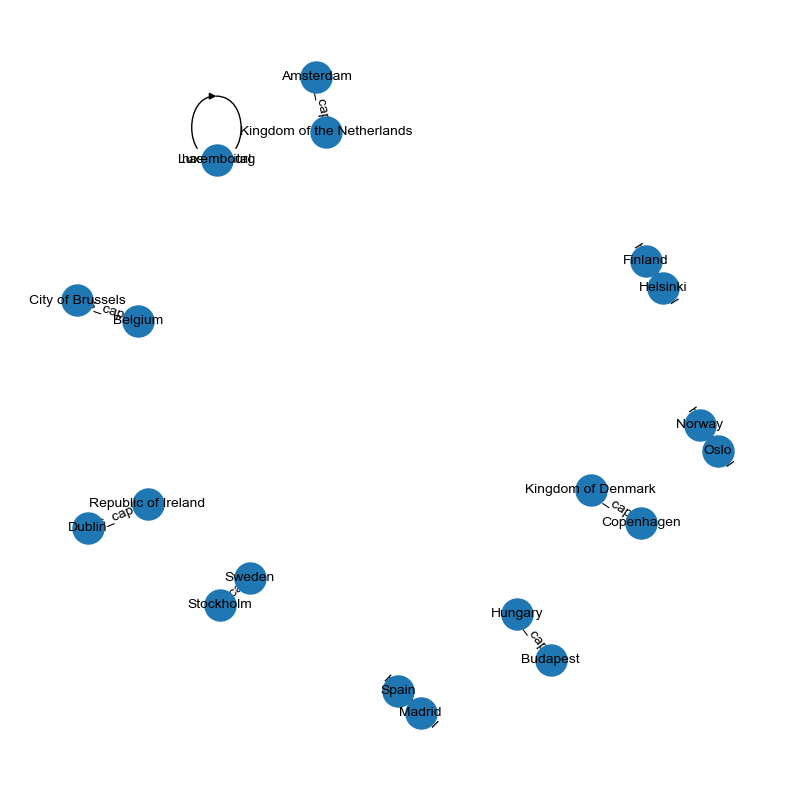

In [161]:
results1 = query_and_graph(test_query1)

In [ ]:
results2 = query_and_graph(test_query3)

In [ ]:
results3 = query_and_graph(test_query4)

# Build Agent

AgentType.OPENAI_FUNCTIONS doesn't work with the vectorDB + RetrievalQA model. 

In [125]:
all_tools = tools_IDLookup  + tool_extract_keywords + [run_sparql_tool] #+ tool_sparql_template

In [126]:
general_template = """
You are trying to generate a SPARQL query based on a natural language question. 
Use the tools in the following order:
1. ExtractKeywords
2. IDAgent (for each item in the output of ExtractKeywords)
3. Run SPARQL query


Note:
* Include LIMIT 50 in sparql query
* If no identifiers found in ItemLookup try PropertyLookup
* If no identifiers found in PropertyLookup try ItemLookup
* DO NOT assume any q-numbers or p-numbers


Question: {question}
"""

#3. SparqlQueryRunner (do NOT assume identifiers, must use ExtractKeywords and IdentifierLookup)

In [127]:
prompt = PromptTemplate(
    template=general_template,
    input_variables=["question"]
)

In [128]:
llm = ChatOpenAI(temperature=0.8, model="gpt-4")
#llm_chain = LLMChain(llm=llm, prompt=prompt)
agent = initialize_agent(all_tools, llm, agent=AgentType.OPENAI_FUNCTIONS, verbose = True)

In [129]:
format_prompt = general_template.format(question='what policies have been proposed to address the issue of income inequality in the developing world?')
agent.run(format_prompt)



> Entering new  chain...

Invoking: `ExtractKeywords` with `what policies have been proposed to address the issue of income inequality in the developing world?`


{'question': 'what policies have been proposed to address the issue of income inequality in the developing world?', 'text': '{ "entities": ["policy", "issue", "income inequality", "developing world"], "properties": ["proposal"] }'}
Invoking: `ItemLookup` with `policy`


{}
Invoking: `PropertyLookup` with `policy`


{}
Invoking: `ItemLookup` with `issue`


{}
Invoking: `PropertyLookup` with `issue`


{'P433': {'label': 'issue', 'description': 'issue of a newspaper, a scientific journal or magazine for reference purpose'}, 'P40': {'label': 'child', 'description': 'subject has object as child. Do not use for stepchildren—use "relative" (P1038), qualified with "type of kinship" (P1039)'}}
Invoking: `ItemLookup` with `income inequality`


{}
Invoking: `PropertyLookup` with `income inequality`


{}
Invoking: `ItemLookup` with `de

'Based on the keywords extracted and the lookups performed, it appears that we were not able to find specific identifiers (q-numbers or p-numbers) for most of the keywords. Given that the question is inquiry about "policies" and "proposals" related to "income inequality" in the "developing world", it might not be feasible to generate a SPARQL query since the identifiers needed for such specific and contextual information are not available in the knowledge graph. It appears this question might be better suited for a text corpus or document database that contains detailed information on the specifics of policies and proposals.'

In [74]:
format_prompt = general_template.format(question='how many children does Bach?')
agent.run(format_prompt)



> Entering new  chain...

Invoking: `ExtractKeywords` with `how many children does Bach have?`


{'question': 'how many children does Bach have?', 'text': '{ "entities": ["Bach", "child"], "properties": ["quantity"] }'}
Invoking: `ItemLookup` with `Bach`


[{'Q1339': {'label': 'Johann Sebastian Bach', 'description': 'German composer (1685–1750)'}}, {'Q1409748': {'label': 'Bach', 'description': 'family name'}}, {'Q936005': {'label': 'Bach', 'description': 'commune in Lot, France'}}, {'Q679998': {'label': 'Bach', 'description': 'municipality in Reutte District, Tyrol, Austria'}}, {'Q144189': {'label': '1814 Bach', 'description': 'main-belt asteroid discovered in 1931'}}, {'Q584238': {'label': 'BACH motif', 'description': 'Musical motif consisting of B flat, A, C, B natural, used by J. S. Bach and other composers'}}, {'Q1072625': {'label': 'Bach', 'description': 'crater on Mercury'}}, {'Q1861386': {'label': 'Bach', 'description': 'French actor and singer'}}, {'Q163727': {'label': "bache

'Johann Sebastian Bach had 20 children.'

In [75]:
format_prompt = general_template.format(question='What are the compounds present in Mouse-ear cress (Arabidopsis thaliana)?')
agent.run(format_prompt)




> Entering new  chain...

Invoking: `ExtractKeywords` with `What are the compounds present in Mouse-ear cress (Arabidopsis thaliana)?`


{'question': 'What are the compounds present in Mouse-ear cress (Arabidopsis thaliana)?', 'text': '{ "entities": ["compound", "Mouse-ear cress", "Arabidopsis thaliana"], "properties": ["presence"] }'}
Invoking: `ItemLookup` with `Mouse-ear cress`


[{'Q158695': {'label': 'Arabidopsis thaliana', 'description': 'species of plant'}}]
Invoking: `ItemLookup` with `compound`


[{'Q11173': {'label': 'chemical compound', 'description': 'pure chemical substance consisting of two or more different chemical elements'}}, {'Q245423': {'label': 'compound', 'description': 'lexeme that consists of more than one stem'}}, {'Q91752': {'label': 'compound', 'description': 'type of fortification'}}, {'Q5156823': {'label': 'compound', 'description': 'cluster of buildings in an enclosure'}}, {'Q190875': {'label': 'cortisol', 'description': 'steroid hormone, in the glucocor

'The compounds present in Mouse-ear cress (Arabidopsis thaliana) are:\n1. [Taxon](http://www.wikidata.org/entity/Q16521)\n2. [Eukaryote](http://www.wikidata.org/entity/Q213907)'

In [69]:
format_prompt = general_template.format(question='Which organisms are known to contain beta-sitosterol?')
agent.run(format_prompt)



> Entering new  chain...

Invoking: `ExtractKeywords` with `Which organisms are known to contain beta-sitosterol?`


{'question': 'Which organisms are known to contain beta-sitosterol?', 'text': '{ "entities": ["organism", "beta-sitosterol"], "properties": ["contain"] }'}
Invoking: `ItemLookup` with `organism`


[{'Q7239': {'label': 'organism', 'description': 'any contiguous alive physical entity; entity or being that is living; an individual living thing, such as one animal, plant, fungus, or bacterium'}}, {'Q1297766': {'label': 'organism (biology)', 'description': 'system of organs of a living being in its entirety'}}, {'Q182726': {'label': 'GMO', 'description': 'organisms whose genetic material has been altered using genetic engineering methods'}}, {'Q55983715': {'label': 'organisms known by a particular common name', 'description': 'living organism Wikidata metaclass'}}, {'Q15753936': {'label': 'Organisms Diversity and Evolution', 'description': 'journal'}}, {'Q55597235': {'label

'PREFIX wd: <http://www.wikidata.org/entity/>\nPREFIX wdt: <http://www.wikidata.org/prop/direct/>\nPREFIX rdfs: <http://www.wikimedia.org/2000/01/rdf-schema#>\n\nSELECT ?organism ?organismLabel\nWHERE\n{\n  ?organism wdt:P527 wd:Q121802 .\n  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }\n}\nLIMIT 50'

## chat react agent with memory and tool_name_schema

In [ ]:
all_tools = tools_IDLookup + [run_sparql_tool] + tool_sparql_template + tool_name_schema

In [ ]:
# Memory
memory_key = "chat_history"
k = 1

# Model
#model_name="gpt-3.5-turbo" #or 'gpt-3.5-turbo'
model_name = "gpt-4"
temperature = 0.8
max_tokens = 3500
max_iterations = 5
early_stopping_method = "generate"

class AgentManager:
    def __init__(self):
        self.memory = None
        self.llm = None
        self.sys_msg = """
        You are an agent that helps answering the question using the tools available. You are an expert in SPARQL queries and wikidata schema. 
        If needed, use the google search tool to collect the identifiers.
        For the sentence provided, generate a corresponding SPARQL request.
        """
        #Use first-person pronouns to ensure a personal, engaging voice. The text must ultimately a page long (800 words). 
        self.conversational_agent = None

    def initialize_conversational_agent(self, agent, tools, memory_key=memory_key, k=k, return_messages=True,
                                        model_name=model_name, temperature=temperature, max_tokens=max_tokens, verbose=True, max_iterations=max_iterations,
                                        early_stopping_method=early_stopping_method):

        self.memory = ConversationBufferWindowMemory(
            memory_key=memory_key,
            k=k,
            return_messages=return_messages
        )

        self.llm = ChatOpenAI(
            model_name=model_name,
            temperature=temperature,
            max_tokens=max_tokens,
            openai_api_key=os.getenv("OPENAI_API_KEY")
        )

        from langchain.agents import initialize_agent

        self.conversational_agent = initialize_agent(
            agent=agent,
            tools=tools,
            llm=self.llm,
            verbose=verbose,
            max_iterations=max_iterations,
            early_stopping_method=early_stopping_method,
            memory=self.memory,
        )

    def create_prompt(self, tools):
        prompt = self.conversational_agent.agent.create_prompt(
            system_message=self.sys_msg,
            tools=tools
        )
        self.conversational_agent.agent.llm_chain.prompt = prompt

chatbot = AgentManager()
chatbot.initialize_conversational_agent(agent='chat-conversational-react-description', tools=all_tools)
chatbot.create_prompt(tools=all_tools)

In [ ]:
chatbot.conversational_agent('describe the chemistry schema?')